In [1]:
import numpy as np

import requests
import re
import time
import os
import pandas as pd
import pickle

from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
from selenium import webdriver
from selenium.webdriver.common.keys import Keys


import diagnostic_plots
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler

% matplotlib inline

/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#save to pick for efficiency



filename_berkely = '/Users/xzhou/github/project_files/project_luther/professor_data_berkely_add_features.pkl' #3986 records
filename_nyu = '/Users/xzhou/github/project_files/project_luther/professor_data_nyu_add_features.pkl' #5607 records
filename_uf = '/Users/xzhou/github/project_files/project_luther/professor_data_uf_add_features.pkl' #5307 records

df_berkely=pd.read_pickle(filename_berkely)
df_nyu=pd.read_pickle(filename_nyu)
df_uf=pd.read_pickle(filename_uf)

In [3]:
print(df_berkely.shape)
print(df_nyu.shape)
print(df_uf.shape)

(3986, 30)
(5607, 30)
(5306, 30)


In [4]:
# define key for each section. This would be used for future references. 
dfs=pd.concat([df_berkely, df_nyu, df_uf],keys=['berkely', 'nyu', 'uf'])
dfs.shape

(14899, 30)

In [5]:
# noted records with no professor name
dfs.tail()

Name  Rating  Level of difficulty  Total reviews  \
uf 5301                        0.0                  2.5              0   
   5302                        0.0                  2.5              0   
   5303  Tina D'Allesandro     4.0                  3.0              1   
   5304          Kay Leary     5.0                  3.0              1   
   5305      Lisa Domenico     4.0                  5.0              1   

         Student size  Type_public  Type_private  Region_west  Region_east  \
uf 5301         52367            1             0            0            0   
   5302         52367            1             0            0            0   
   5303         52367            1             0            0            0   
   5304         52367            1             0            0            0   
   5305         52367            1             0            0            0   

         Region_south      ...       Hilarious  Inspirational  Lecture heavy  \
uf 5301             1      ...             0.0            0.0            0.0   
   5302             1      ...             0.0            0.0            0.0   
   5303             1      ...             0.0            0.0            0.0   
   5304             1      ...             0.0            0.0            0.0   
   5305             1      ...             0.0            0.0            0.0   

         Lots of homework  Participation matters  Respected  \
uf 5301               0.0                   0.00        0.0   
   5302               0.0                   0.00        0.0   
   5303               0.0                   0.33        0.0   
   5304               0.0                   0.00        0.0   
   5305               0.0                   0.33        0.0   

         Skip class? you won't pass.  So many papers  Test heavy  Tough grader  
uf 5301                          0.0             0.0         0.0           0.0  
   5302                          0.0             0.0         0.0           0.0  
   5303                          0.0             0.0         0.0           0.0  
   5304                          0.0             0.0         0.0           0.0  
   5305                          0.0             0.0         0.0           0.0  

[5 rows x 30 columns]

In [6]:
dfs[dfs.Name==""].head()

Name  Rating  Level of difficulty  Total reviews  Student size  \
berkely 244          0.0                  2.5              0         41910   
        274          0.0                  2.5              0         41910   
        376          0.0                  2.5              0         41910   
        416          0.0                  2.5              0         41910   
        478          0.0                  2.5              0         41910   

             Type_public  Type_private  Region_west  Region_east  \
berkely 244            1             0            1            0   
        274            1             0            1            0   
        376            1             0            1            0   
        416            1             0            1            0   
        478            1             0            1            0   

             Region_south      ...       Hilarious  Inspirational  \
berkely 244             0      ...             0.0            0.0   
        274             0      ...             0.0            0.0   
        376             0      ...             0.0            0.0   
        416             0      ...             0.0            0.0   
        478             0      ...             0.0            0.0   

             Lecture heavy  Lots of homework  Participation matters  \
berkely 244            0.0               0.0                    0.0   
        274            0.0               0.0                    0.0   
        376            0.0               0.0                    0.0   
        416            0.0               0.0                    0.0   
        478            0.0               0.0                    0.0   

             Respected  Skip class? you won't pass.  So many papers  \
berkely 244        0.0                          0.0             0.0   
        274        0.0                          0.0             0.0   
        376        0.0                          0.0             0.0   
        416        0.0                          0.0             0.0   
        478        0.0                          0.0             0.0   

             Test heavy  Tough grader  
berkely 244         0.0           0.0  
        274         0.0           0.0  
        376         0.0           0.0  
        416         0.0           0.0  
        478         0.0           0.0  

[5 rows x 30 columns]

In [7]:
# remove records that don't have professor names
dfs_smaller=dfs[dfs.Name!=""]
dfs_smaller.shape

(13238, 30)

In [8]:
dfs_smaller=dfs_smaller.fillna(0)

In [9]:
dfs_smaller.columns

Index(['Name', 'Rating', 'Level of difficulty', 'Total reviews',
       'Student size', 'Type_public', 'Type_private', 'Region_west',
       'Region_east', 'Region_south', 'Accessible outside class',
       'Amazing lectures', 'Beware of pop quizzes', 'Caring',
       'Clear grading criteria', 'Extra credit', 'Get ready to read',
       'Gives good feedback', 'Graded by few things', 'Group projects',
       'Hilarious', 'Inspirational', 'Lecture heavy', 'Lots of homework',
       'Participation matters', 'Respected', 'Skip class? you won't pass.',
       'So many papers', 'Test heavy', 'Tough grader'],
      dtype='object')

In [10]:
# Clear out records without tags
dfs_smaller.insert(5,'Total score for Tags', dfs_smaller.sum(axis=1)-dfs_smaller['Rating']-dfs_smaller['Level of difficulty']-dfs_smaller['Total reviews']-dfs_smaller['Student size']-dfs_smaller['Type_public']-dfs_smaller['Type_private']-dfs_smaller['Region_west']-dfs_smaller['Region_east']-dfs_smaller['Region_south'])
dfs_clean=dfs_smaller[dfs_smaller['Total score for Tags']>0.9]
dfs_clean=dfs_clean.drop(['Total score for Tags'], 1)
dfs_clean.head()

Name  Rating  Level of difficulty  Total reviews  \
berkely 1   Chris Dolder     4.8                  3.9              9   
        2   Bob Calonico     4.7                  1.6             29   
        4    Mary Kelsey     4.6                  1.6             63   
        5    John Searle     3.6                  3.1             47   
        8  William Hanks     4.4                  2.2             25   

           Student size  Type_public  Type_private  Region_west  Region_east  \
berkely 1         41910            1             0            1            0   
        2         41910            1             0            1            0   
        4         41910            1             0            1            0   
        5         41910            1             0            1            0   
        8         41910            1             0            1            0   

           Region_south      ...       Hilarious  Inspirational  \
berkely 1             0      ...            0.00           0.50   
        2             0      ...            0.26           0.32   
        4             0      ...            0.00           0.08   
        5             0      ...            0.21           0.07   
        8             0      ...            0.00           0.33   

           Lecture heavy  Lots of homework  Participation matters  Respected  \
berkely 1           0.00               0.0                   0.00       0.00   
        2           0.00               0.0                   0.00       0.11   
        4           0.04               0.0                   0.08       0.12   
        5           0.00               0.0                   0.00       0.21   
        8           0.00               0.0                   0.00       0.00   

           Skip class? you won't pass.  So many papers  Test heavy  \
berkely 1                         0.00             0.0         0.0   
        2                         0.00             0.0         0.0   
        4                         0.04             0.0         0.0   
        5                         0.00             0.0         0.0   
        8                         0.33             0.0         0.0   

           Tough grader  
berkely 1          0.00  
        2          0.00  
        4          0.04  
        5          0.07  
        8          0.00  

[5 rows x 30 columns]

In [11]:
# focus on professor with meaningful number of reviews

dfs_clean=dfs_clean[dfs_clean['Total reviews']>=3]

In [12]:
dfs_clean.shape

(4798, 30)

In [13]:
dfs_clean.columns

Index(['Name', 'Rating', 'Level of difficulty', 'Total reviews',
       'Student size', 'Type_public', 'Type_private', 'Region_west',
       'Region_east', 'Region_south', 'Accessible outside class',
       'Amazing lectures', 'Beware of pop quizzes', 'Caring',
       'Clear grading criteria', 'Extra credit', 'Get ready to read',
       'Gives good feedback', 'Graded by few things', 'Group projects',
       'Hilarious', 'Inspirational', 'Lecture heavy', 'Lots of homework',
       'Participation matters', 'Respected', 'Skip class? you won't pass.',
       'So many papers', 'Test heavy', 'Tough grader'],
      dtype='object')

In [14]:
dfs_clean.describe()

,Rating,Level of difficulty,Total reviews,Student size,Type_public,Type_private,Region_west,Region_east,Region_south,Accessible outside class,...,Hilarious,Inspirational,Lecture heavy,Lots of homework,Participation matters,Respected,Skip class? you won't pass.,So many papers,Test heavy,Tough grader
count,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,...,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000,4798.000000
mean,3.808629,3.011192,17.503126,52447.240725,0.574198,0.425802,0.264902,0.425802,0.309296,0.036711,...,0.046765,0.063287,0.052209,0.047203,0.062805,0.079454,0.058343,0.012386,0.017614,0.087136
std,0.878436,0.752749,26.916727,6931.836761,0.494516,0.494516,0.441327,0.494516,0.462251,0.076697,...,0.097551,0.106778,0.112295,0.098289,0.109910,0.115346,0.104283,0.050403,0.056999,0.145612
min,1.000000,1.000000,3.000000,41910.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.300000,2.500000,5.000000,41910.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,3.000000,10.000000,52367.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.500000,3.500000,20.000000,59061.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.040000,...,0.050000,0.100000,0.067500,0.050000,0.100000,0.130000,0.090000,0.000000,0.000000,0.140000
max,5.000000,5.000000,507.000000,59061.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000


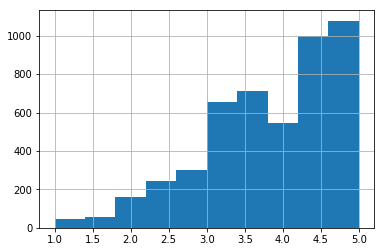

In [15]:
dfs_clean['Rating'].hist()

In [16]:
# Perform transformation of Total reviews and drop unnecessary fields
dfs_clean['Total reviews']=np.log(dfs_clean['Total reviews'])
dfs_clean=dfs_clean.drop('Name', axis=1)
dfs_clean.head()

Rating  Level of difficulty  Total reviews  Student size  \
berkely 1     4.8                  3.9       2.197225         41910   
        2     4.7                  1.6       3.367296         41910   
        4     4.6                  1.6       4.143135         41910   
        5     3.6                  3.1       3.850148         41910   
        8     4.4                  2.2       3.218876         41910   

           Type_public  Type_private  Region_west  Region_east  Region_south  \
berkely 1            1             0            1            0             0   
        2            1             0            1            0             0   
        4            1             0            1            0             0   
        5            1             0            1            0             0   
        8            1             0            1            0             0   

           Accessible outside class      ...       Hilarious  Inspirational  \
berkely 1                      0.00      ...            0.00           0.50   
        2                      0.05      ...            0.26           0.32   
        4                      0.04      ...            0.00           0.08   
        5                      0.00      ...            0.21           0.07   
        8                      0.00      ...            0.00           0.33   

           Lecture heavy  Lots of homework  Participation matters  Respected  \
berkely 1           0.00               0.0                   0.00       0.00   
        2           0.00               0.0                   0.00       0.11   
        4           0.04               0.0                   0.08       0.12   
        5           0.00               0.0                   0.00       0.21   
        8           0.00               0.0                   0.00       0.00   

           Skip class? you won't pass.  So many papers  Test heavy  \
berkely 1                         0.00             0.0         0.0   
        2                         0.00             0.0         0.0   
        4                         0.04             0.0         0.0   
        5                         0.00             0.0         0.0   
        8                         0.33             0.0         0.0   

           Tough grader  
berkely 1          0.00  
        2          0.00  
        4          0.04  
        5          0.07  
        8          0.00  

[5 rows x 29 columns]

In [17]:
#sns.pairplot(dfs_clean,  size = 2, aspect=1.5);

In [18]:
# Define a function to perform training and test sets split:

def tt_split(df, y_column, test_size):
    X=df.drop(y_column, 1)
    y=df[y_column]
    return train_test_split(X, y, test_size=test_size, random_state=8)

In [19]:
# prior to normalize
X_train, X_test, y_train, y_test=tt_split(dfs_clean, 'Rating', 0.8)

model1=sm.OLS(y_train, sm.add_constant(X_train))
fit1=model1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     33.62
Date:                Fri, 20 Jul 2018   Prob (F-statistic):          7.27e-109
Time:                        01:56:56   Log-Likelihood:                -949.69
No. Observations:                 959   AIC:                             1949.
Df Residuals:                     934   BIC:                             2071.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.2528      0.061      4.158      0.000       0.134       0.372
Level of difficulty            -0.2547      0.033     -7.682      0.000      -0.320      -0.190
Total reviews                  -0.0155      0.024     -0.637      0.524      -0.063       0.032
Student size                    0.0001    3.3e-05      4.279      0.000    7.65e-05       0.000
Type_public                     0.6302      0.148      4.269      0.000       0.341       0.920
Type_private                   -0.3773      0.087     -4.328      0.000      -0.548      -0.206
Region_west                     1.0246      0.249      4.108      0.000       0.535       1.514
Region_east                    -0.3773      0.087     -4.328      0.000      -0.548      -0.206
Region_south                   -0.3944      0.104     -3.779      0.000      -0.599      -0.190
Accessible outside class       -2.1003      1.865     -1.126      0.260      -5.761       1.560
Amazing lectures               -1.9157      1.852     -1.034      0.301      -5.550       1.718
Beware of pop quizzes          -3.3974      1.917     -1.772      0.077      -7.159       0.365
Caring                         -2.6671      1.857     -1.437      0.151      -6.311       0.976
Clear grading criteria         -3.3657      1.856     -1.814      0.070      -7.008       0.276
Extra credit                   -2.9029      1.860     -1.561      0.119      -6.553       0.747
Get ready to read              -3.7070      1.852     -2.002      0.046      -7.342      -0.072
Gives good feedback            -2.8392      1.859     -1.528      0.127      -6.487       0.808
Graded by few things           -4.2048      1.868     -2.251      0.025      -7.870      -0.539
Group projects                 -4.6637      1.867     -2.497      0.013      -8.329      -0.999
Hilarious                      -2.8966      1.849     -1.567      0.117      -6.525       0.731
Inspirational                  -2.7624      1.857     -1.487      0.137      -6.407       0.883
Lecture heavy                  -4.0163      1.853     -2.168      0.030      -7.652      -0.380
Lots of homework               -4.0522      1.862     -2.177      0.030      -7.705      -0.399
Participation matters          -2.8363      1.864     -1.522      0.128      -6.494       0.821
Respected                      -2.2358      1.840     -1.215      0.225      -5.848       1.376
Skip class? you won't pass.    -3.5508      1.860     -1.909      0.057      -7.202       0.100
So many papers                 -5.7155      1.926     -2.967      0.003      -9.496      -1.935
Test heavy                     -5.0964      1.884     -2.705      0.007      -8.794      -1.399
Tough grader                   -4.5976      1.846     -2.491      0.013      -8.220      -0.975
===========

In [20]:
# Model: noted y is not normal distribution. Leave it untransformed in this scenario

# Perform training and testing splits

X_train, X_test, y_train, y_test=tt_split(dfs_clean, 'Rating', 0.8)

# normalize training set

ssX = StandardScaler()
X_train_scaled = ssX.fit_transform(X_train)


model1=sm.OLS(y_train, sm.add_constant(X_train_scaled))
fit1=model1.fit()
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     33.62
Date:                Fri, 20 Jul 2018   Prob (F-statistic):          7.27e-109
Time:                        01:56:56   Log-Likelihood:                -949.69
No. Observations:                 959   AIC:                             1949.
Df Residuals:                     934   BIC:                             2071.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8173      0.021    179.097      0.000       3.775       3.859
x1            -0.1924      0.025     -7.682      0.000      -0.242      -0.143
x2            -0.0141      0.022     -0.637      0.524      -0.058       0.029
x3             0.0049      0.007      0.666      0.505      -0.009       0.019
x4             0.0035      0.005      0.647      0.518      -0.007       0.014
x5            -0.0035      0.005     -0.647      0.518      -0.014       0.007
x6            -0.0099      0.011     -0.921      0.357      -0.031       0.011
x7            -0.0035      0.005     -0.647      0.518      -0.014       0.007
x8             0.0131      0.012      1.066      0.287      -0.011       0.037
x9            -0.1520      0.135     -1.126      0.260      -0.417       0.113
x10           -0.2003      0.194     -1.034      0.301      -0.580       0.180
x11           -0.1508      0.085     -1.772      0.077      -0.318       0.016
x12           -0.3081      0.214     -1.437      0.151      -0.729       0.113
x13           -0.3505      0.193     -1.814      0.070      -0.730       0.029
x14           -0.1956      0.125     -1.561      0.119      -0.442       0.050
x15           -0.4787      0.239     -2.002      0.046      -0.948      -0.009
x16           -0.3465      0.227     -1.528      0.127      -0.792       0.099
x17           -0.3246      0.144     -2.251      0.025      -0.608      -0.042
x18           -0.3420      0.137     -2.497      0.013      -0.611      -0.073
x19           -0.3038      0.194     -1.567      0.117      -0.684       0.077
x20           -0.3119      0.210     -1.487      0.137      -0.723       0.100
x21           -0.5061      0.233     -2.168      0.030      -0.964      -0.048
x22           -0.3964      0.182     -2.177      0.030      -0.754      -0.039
x23           -0.2914      0.191     -1.522      0.128      -0.667       0.084
x24           -0.2505      0.206     -1.215      0.225      -0.655       0.154
x25           -0.3725      0.195     -1.909      0.057      -0.756       0.010
x26           -0.2100      0.071     -2.967      0.003      -0.349      -0.071
x27           -0.2283      0.084     -2.705      0.007      -0.394      -0.063
x28           -0.6788      0.273     -2.491      0.013      -1.214      -0.144
==============================================================================
Omnibus:                       61.682   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.841
Skew:                          -0.615   Prob(JB):                     9.24e-17
Kurtosis:                       3.579   Cond. No.                     2.28e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is

In [21]:
plt.style.use('seaborn')

In [70]:
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 32}

plt.rc('font', **font)

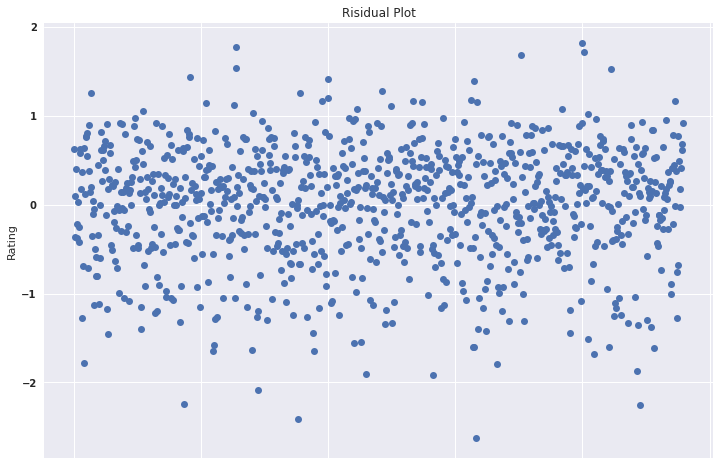

In [71]:

fit1.resid.plot(style='o', figsize=(12,8))
plt.ylabel('Rating')
plt.title('Risidual Plot')
plt.rc('font', **font)
plt.show()

In [23]:
#diagnostic_plots.diagnostic_plots(dfs_clean.drop('Rating', axis=1), dfs_clean['Rating'], fit1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     30.12
Date:                Fri, 20 Jul 2018   Prob (F-statistic):           4.21e-99
Time:                        01:56:57   Log-Likelihood:                 371.77
No. Observations:                 959   AIC:                            -693.5
Df Residuals:                     934   BIC:                            -571.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0715      0.015      4.665      0.000       0.041       0.102
Level of difficulty            -0.0592      0.008     -7.086      0.000      -0.076      -0.043
Total reviews                   0.0082      0.006      1.344      0.179      -0.004       0.020
Student size                 3.963e-05   8.32e-06      4.763      0.000    2.33e-05     5.6e-05
Type_public                     0.1756      0.037      4.720      0.000       0.103       0.249
Type_private                   -0.1041      0.022     -4.737      0.000      -0.147      -0.061
Region_west                     0.2914      0.063      4.635      0.000       0.168       0.415
Region_east                    -0.1041      0.022     -4.737      0.000      -0.147      -0.061
Region_south                   -0.1158      0.026     -4.401      0.000      -0.167      -0.064
Accessible outside class       -0.6907      0.470     -1.469      0.142      -1.613       0.232
Amazing lectures               -0.6326      0.467     -1.355      0.176      -1.549       0.284
Beware of pop quizzes          -0.8790      0.483     -1.819      0.069      -1.827       0.069
Caring                         -0.8033      0.468     -1.716      0.086      -1.722       0.115
Clear grading criteria         -0.9279      0.468     -1.983      0.048      -1.846      -0.010
Extra credit                   -0.8275      0.469     -1.765      0.078      -1.748       0.093
Get ready to read              -1.0310      0.467     -2.208      0.027      -1.947      -0.115
Gives good feedback            -0.8260      0.469     -1.763      0.078      -1.745       0.094
Graded by few things           -1.1026      0.471     -2.342      0.019      -2.027      -0.179
Group projects                 -1.2307      0.471     -2.614      0.009      -2.155      -0.307
Hilarious                      -0.8491      0.466     -1.822      0.069      -1.764       0.065
Inspirational                  -0.8072      0.468     -1.724      0.085      -1.726       0.112
Lecture heavy                  -1.1080      0.467     -2.372      0.018      -2.025      -0.191
Lots of homework               -1.1077      0.469     -2.360      0.018      -2.029      -0.187
Participation matters          -0.8099      0.470     -1.724      0.085      -1.732       0.112
Respected                      -0.7001      0.464     -1.509      0.132      -1.611       0.210
Skip class? you won't pass.    -0.9535      0.469     -2.033      0.042      -1.874      -0.033
So many papers                 -1.5344      0.486     -3.160      0.002      -2.487      -0.581
Test heavy                     -1.3536      0.475     -2.850      0.004      -2.286      -0.422
Tough grader                   -1.3080      0.465     -2.811      0.005      -2.221      -0.395
===========

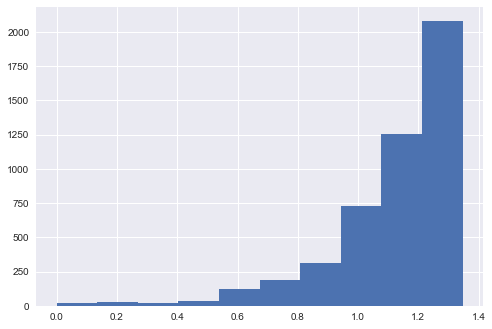

In [24]:
# Tested Box transformation and noted worse result

from scipy import stats

dfs_box=dfs_clean.copy()
lamb=stats.boxcox_normmax(dfs_box.Rating, brack=(-1.9, 1.9))

dfs_box.Rating=(np.power(dfs_box.Rating,-0.2282)-1)/-0.2282

plt.hist(dfs_box.Rating);


X_train2, X_test2, y_train2, y_test2=tt_split(dfs_box, 'Rating', 0.8)
ssX2 = StandardScaler()
X_train_scaled2 = ssX.fit_transform(X_train2)



model2=sm.OLS(y_train2, sm.add_constant(X_train2))
fit2=model2.fit()
fit2.summary()

In [25]:
# Tested log transform of y, and noted worse result

dfs_log=dfs_clean.copy()
dfs_log['Rating']=np.log(dfs_log['Rating'])

X_train3, X_test3, y_train3, y_test3=tt_split(dfs_log, 'Rating', 0.8)
ssX3 = StandardScaler()
X_train_scaled3 = ssX.fit_transform(X_train3)


model3=sm.OLS(y_train3, sm.add_constant(X_train3))
fit3=model3.fit()
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     31.17
Date:                Fri, 20 Jul 2018   Prob (F-statistic):          4.51e-102
Time:                        01:56:57   Log-Likelihood:                 144.07
No. Observations:                 959   AIC:                            -238.1
Df Residuals:                     934   BIC:                            -116.5
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0863      0.019      4.439      0.000       0.048       0.124
Level of difficulty            -0.0769      0.011     -7.259      0.000      -0.098      -0.056
Total reviews                   0.0075      0.008      0.963      0.336      -0.008       0.023
Student size                  4.79e-05   1.06e-05      4.539      0.000    2.72e-05    6.86e-05
Type_public                     0.2125      0.047      4.504      0.000       0.120       0.305
Type_private                   -0.1262      0.028     -4.529      0.000      -0.181      -0.072
Region_west                     0.3513      0.080      4.406      0.000       0.195       0.508
Region_east                    -0.1262      0.028     -4.529      0.000      -0.181      -0.072
Region_south                   -0.1388      0.033     -4.159      0.000      -0.204      -0.073
Accessible outside class       -0.8327      0.596     -1.397      0.163      -2.003       0.337
Amazing lectures               -0.7628      0.592     -1.289      0.198      -1.924       0.399
Beware of pop quizzes          -1.1096      0.613     -1.811      0.070      -2.312       0.093
Caring                         -0.9853      0.593     -1.660      0.097      -2.150       0.179
Clear grading criteria         -1.1576      0.593     -1.951      0.051      -2.322       0.007
Extra credit                   -1.0256      0.594     -1.725      0.085      -2.192       0.141
Get ready to read              -1.2853      0.592     -2.171      0.030      -2.447      -0.123
Gives good feedback            -1.0201      0.594     -1.717      0.086      -2.186       0.146
Graded by few things           -1.3895      0.597     -2.327      0.020      -2.561      -0.218
Group projects                 -1.5524      0.597     -2.601      0.009      -2.724      -0.381
Hilarious                      -1.0471      0.591     -1.772      0.077      -2.207       0.113
Inspirational                  -0.9954      0.594     -1.677      0.094      -2.160       0.170
Lecture heavy                  -1.3839      0.592     -2.337      0.020      -2.546      -0.222
Lots of homework               -1.3856      0.595     -2.329      0.020      -2.553      -0.218
Participation matters          -1.0022      0.596     -1.682      0.093      -2.171       0.167
Respected                      -0.8521      0.588     -1.448      0.148      -2.007       0.302
Skip class? you won't pass.    -1.1965      0.595     -2.012      0.044      -2.363      -0.029
So many papers                 -1.9306      0.616     -3.135      0.002      -3.139      -0.722
Test heavy                     -1.7045      0.602     -2.830      0.005      -2.886      -0.523
Tough grader                   -1.6241      0.590     -2.753      0.006      -2.782      -0.466
===========

In [26]:
dfs_clean.columns

Index(['Rating', 'Level of difficulty', 'Total reviews', 'Student size',
       'Type_public', 'Type_private', 'Region_west', 'Region_east',
       'Region_south', 'Accessible outside class', 'Amazing lectures',
       'Beware of pop quizzes', 'Caring', 'Clear grading criteria',
       'Extra credit', 'Get ready to read', 'Gives good feedback',
       'Graded by few things', 'Group projects', 'Hilarious', 'Inspirational',
       'Lecture heavy', 'Lots of homework', 'Participation matters',
       'Respected', 'Skip class? you won't pass.', 'So many papers',
       'Test heavy', 'Tough grader'],
      dtype='object')

In [27]:
# Ran iterations of models and only keep key features that can impact rating

dfs_clean_smaller=dfs_clean.loc[:,['Rating', 'Level of difficulty',  
        'Accessible outside class', 'Amazing lectures','Caring', 'Clear grading criteria',
        'Gives good feedback',
        'Hilarious', 'Inspirational',
         'Participation matters',
       'Respected', 'Skip class? you won\'t pass.' 
        ]]

In [28]:
# model 4 with lasso approach

In [29]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [30]:
X_train, X_test, y_train, y_test=tt_split(dfs_clean_smaller, 'Rating', 0.8)

In [31]:
SSX4=StandardScaler()
X_train_scaled=SSX4.fit_transform(X_train)
X_test_scaled=SSX4.transform(X_test)

In [32]:
# define pipeline

est=make_pipeline(PolynomialFeatures(2), Lasso(1))

In [33]:
est.get_params().keys()

dict_keys(['memory', 'steps', 'polynomialfeatures', 'lasso', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'lasso__alpha', 'lasso__copy_X', 'lasso__fit_intercept', 'lasso__max_iter', 'lasso__normalize', 'lasso__positive', 'lasso__precompute', 'lasso__random_state', 'lasso__selection', 'lasso__tol', 'lasso__warm_start'])

In [34]:
#est.get_params().keys()
#est.set_params(polynomialfeatures__degree=4)

In [35]:
params = {'lasso__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1] , 'polynomialfeatures__degree': [1, 2, 3]}
grid = GridSearchCV(est, param_grid=params, cv=5)
grid.fit(X_train_scaled, y_train)

/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('lasso', Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'polynomialfeatures__degree': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
grid.best_estimator_.get_params()['lasso'].coef_

array([ 0.        , -0.22535961,  0.14365742,  0.22973502,  0.16639805,
        0.0845174 ,  0.15943565,  0.1285289 ,  0.15785578,  0.13537392,
        0.20265492,  0.06205456])

In [37]:
grid.best_params_

{'lasso__alpha': 0.001, 'polynomialfeatures__degree': 1}

In [38]:
grid.score(X_test_scaled, y_test)

0.4057764442229708

In [39]:
X_train.head()

Level of difficulty  Accessible outside class  Amazing lectures  \
berkely 692                   3.9                      0.00               0.0   
nyu     489                   3.5                      0.00               0.0   
uf      1420                  3.0                      0.08               0.0   
        4245                  3.3                      0.00               0.0   
berkely 206                   1.9                      0.00               0.0   

              Caring  Clear grading criteria  Gives good feedback  Hilarious  \
berkely 692     0.00                    0.00                 0.00       0.00   
nyu     489     0.00                    0.25                 0.00       0.00   
uf      1420    0.08                    0.00                 0.00       0.08   
        4245    0.08                    0.00                 0.17       0.00   
berkely 206     0.20                    0.00                 0.00       0.00   

              Inspirational  Participation matters  Respected  \
berkely 692            0.00                    0.0       0.00   
nyu     489            0.00                    0.0       0.00   
uf      1420           0.25                    0.0       0.17   
        4245           0.08                    0.0       0.00   
berkely 206            0.40                    0.0       0.40   

              Skip class? you won't pass.  
berkely 692                          0.00  
nyu     489                          0.00  
uf      1420                         0.00  
        4245                         0.25  
berkely 206                          0.00

In [40]:
# Modle 5 with Ridge model

degree=2
alphas= 1  #[1e-5, 1e-4, 1e-3,1e-2,1e-1]


est2=make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alphas))

In [41]:
est2.get_params().keys()

dict_keys(['memory', 'steps', 'polynomialfeatures', 'ridge', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'ridge__alpha', 'ridge__copy_X', 'ridge__fit_intercept', 'ridge__max_iter', 'ridge__normalize', 'ridge__random_state', 'ridge__solver', 'ridge__tol'])

In [42]:
params2 = {'ridge__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1] , 'polynomialfeatures__degree': [1, 2, 3]}
grid2 = GridSearchCV(est2, param_grid=params2, cv=5)
grid2.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'polynomialfeatures__degree': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [43]:
grid2.best_estimator_.get_params()['ridge'].coef_

array([ 0.        , -0.22503536,  0.14483339,  0.23082068,  0.16745131,
        0.08628523,  0.16073567,  0.1298527 ,  0.15906314,  0.13681713,
        0.20366588,  0.06403286])

In [44]:
grid2.best_params_

{'polynomialfeatures__degree': 1, 'ridge__alpha': 1}

In [45]:
grid2.score(X_test_scaled, y_test)

0.4055806422490368

In [46]:
# Model 6: Elastic Net
from sklearn.linear_model import ElasticNet

In [47]:
degree=2
alphas=1

est3=make_pipeline(PolynomialFeatures(degree), ElasticNet(alpha=alphas))

In [48]:
est3.get_params().keys()

dict_keys(['memory', 'steps', 'polynomialfeatures', 'elasticnet', 'polynomialfeatures__degree', 'polynomialfeatures__include_bias', 'polynomialfeatures__interaction_only', 'elasticnet__alpha', 'elasticnet__copy_X', 'elasticnet__fit_intercept', 'elasticnet__l1_ratio', 'elasticnet__max_iter', 'elasticnet__normalize', 'elasticnet__positive', 'elasticnet__precompute', 'elasticnet__random_state', 'elasticnet__selection', 'elasticnet__tol', 'elasticnet__warm_start'])

In [49]:
params = {'elasticnet__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1] , 'polynomialfeatures__degree': [1, 2, 3]}
grid3 = GridSearchCV(est3, param_grid=params, cv=5)
grid3.fit(X_train_scaled, y_train)

/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/xzhou/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not co

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('elasticnet', ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'polynomialfeatures__degree': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [50]:
grid3.best_params_

{'elasticnet__alpha': 0.01, 'polynomialfeatures__degree': 1}

In [51]:
grid3.best_estimator_.get_params()['elasticnet'].coef_

array([ 0.        , -0.22606538,  0.13724594,  0.22296543,  0.16071689,
        0.07571041,  0.15233942,  0.12175314,  0.15159818,  0.12760483,
        0.19684617,  0.05197278])

In [52]:
grid3.score(X_test_scaled, y_test)

0.406398317554983

In [53]:
X_train.head()

Level of difficulty  Accessible outside class  Amazing lectures  \
berkely 692                   3.9                      0.00               0.0   
nyu     489                   3.5                      0.00               0.0   
uf      1420                  3.0                      0.08               0.0   
        4245                  3.3                      0.00               0.0   
berkely 206                   1.9                      0.00               0.0   

              Caring  Clear grading criteria  Gives good feedback  Hilarious  \
berkely 692     0.00                    0.00                 0.00       0.00   
nyu     489     0.00                    0.25                 0.00       0.00   
uf      1420    0.08                    0.00                 0.00       0.08   
        4245    0.08                    0.00                 0.17       0.00   
berkely 206     0.20                    0.00                 0.00       0.00   

              Inspirational  Participation matters  Respected  \
berkely 692            0.00                    0.0       0.00   
nyu     489            0.00                    0.0       0.00   
uf      1420           0.25                    0.0       0.17   
        4245           0.08                    0.0       0.00   
berkely 206            0.40                    0.0       0.40   

              Skip class? you won't pass.  
berkely 692                          0.00  
nyu     489                          0.00  
uf      1420                         0.00  
        4245                         0.25  
berkely 206                          0.00

In [57]:
X_final=X_train.drop(['Clear grading criteria', "Skip class? you won't pass."],1)

In [59]:
X_final.columns

Index(['Level of difficulty', 'Accessible outside class', 'Amazing lectures',
       'Caring', 'Gives good feedback', 'Hilarious', 'Inspirational',
       'Participation matters', 'Respected'],
      dtype='object')

In [60]:
X_final.shape

(959, 9)

In [54]:
fit4.resid.plot(style='o', figsize=(12,8));

NameError: name 'fit4' is not defined

In [ ]:
diagnostic_plots.diagnostic_plots(dfs_clean.drop(['Name','Rating'], axis=1), dfs_clean['Rating'], fit)

In [ ]:
dfs_log.describe()